In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/Leather\ Defect\ Classification /content

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.models.densenet import _DenseLayer, _Transition
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
from collections import OrderedDict
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import re
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
from torch import Tensor
from torch.jit.annotations import List
from torchvision.models.densenet import _DenseLayer,_Transition

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:

trans = transforms.Compose([
                    transforms.Resize((227,227)),
                    transforms.ToTensor(),
])

In [ ]:
full_dataset=datasets.ImageFolder("/content/Leather Defect Classification", transform=trans)
len(full_dataset)

3600

In [ ]:
train_size = int(0.76 * len(full_dataset))
valid_size = int(0.12 * len(full_dataset))
test_size = int(0.12 * len(full_dataset))
train_dataset, test_dataset, valid_dataset = torch.utils.data.random_split(full_dataset, [train_size,valid_size, test_size])

In [ ]:
dataloader_train= DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_valid= DataLoader(valid_dataset, batch_size=32,shuffle=True)
dataloader_test= DataLoader(test_dataset, batch_size=32,shuffle=True)

In [ ]:
class _Csp_Transition(torch.nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Csp_Transition, self).__init__()
        self.add_module('norm', torch.nn.BatchNorm2d(num_input_features))
        self.add_module('relu', torch.nn.ReLU(inplace=True))
        self.add_module('conv', torch.nn.Conv2d(num_input_features, num_output_features,kernel_size=1, stride=1, bias=False))

In [ ]:
class _Csp_DenseBlock(torch.nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False,transition = False):
        super(_Csp_DenseBlock,self).__init__()
        self.csp_num_features1 = num_input_features//2
        self.csp_num_features2 = num_input_features - self.csp_num_features1
        transition_input_features = num_layers * growth_rate
        for i in range(num_layers):
            layer = _DenseLayer(
                self.csp_num_features2 + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d'%(i+1),layer)
        self.transition = _Csp_Transition(transition_input_features,transition_input_features//2) if transition else None

    def forward(self,x):
        
        features = [x[:,self.csp_num_features1:,...]]
        for name,layer in self.named_children():
            if 'denselayer' in name:
                new_feature = layer(features)
                features.append(new_feature)

        dense = torch.cat(features[1:],1)
        if self.transition is not None:
            
            dense = self.transition(dense)
        return torch.cat([x[:,:self.csp_num_features1,...],dense],1)


In [ ]:
feat=[]
for i in range(5):
  feat.append(torch.full((1,5,3,3),i))
y=torch.full((5,5,3,3),7)
a=torch.cat(feat[1:],1)
a.shape

torch.Size([1, 20, 3, 3])

In [ ]:

class Csp_DenseNet(torch.nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),num_init_features=64, 
                 transitionBlock = False,transitionDense = True,bn_size=4, drop_rate=0, num_classes=6, memory_efficient=False):
        super(Csp_DenseNet,self).__init__()
        self.features = torch.nn.Sequential(OrderedDict([
            ('conv0', torch.nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,padding=3, bias=False)),
            ('norm0', torch.nn.BatchNorm2d(num_init_features)),
            ('relu0', torch.nn.ReLU(inplace=True)),
            ('pool0', torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))            
        
        num_features = num_init_features
        for i,num_layers in enumerate(block_config):
            block = _Csp_DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
                transition=transitionBlock
            )
            self.features.add_module('denseblock%d'%(i+1),block)
            num_features = num_features//2 + num_layers * growth_rate // 2
            if (i != len(block_config)-1) and transitionDense:
                trans = _Transition(num_input_features=num_features,num_output_features=num_features//2)
                self.features.add_module('transition%d'%(i+1),trans)
                num_features = num_features//2
        self.features.add_module('norm5', torch.nn.BatchNorm2d(num_features))
        

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        
        out = torch.nn.functional.relu(features, inplace=True)
        out = torch.nn.functional.adaptive_avg_pool2d(out, (1, 1))

        return out

In [ ]:
net= Csp_DenseNet(32,(8,14,18),64,True,True)
net.to(device)

Csp_DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _Csp_DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
classifier = torch.nn.Linear(354, 6)
classifier.to(device)

Linear(in_features=354, out_features=6, bias=True)

In [ ]:
class BiFPN(torch.nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),num_init_features=64,transitionBlock = False,transitionDense = True,bn_size=4, drop_rate=0, num_classes=6, memory_efficient=False):
        super(BiFPN,self).__init__():

    def forward(self, x):
        features = self.features(x)
        
        out = torch.nn.functional.relu(features, inplace=True)
        out = torch.nn.functional.adaptive_avg_pool2d(out, (1, 1))

        return out

SyntaxError: ignored

In [ ]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    total_correct = 0
    total_images = 0
    for i, data in enumerate(dataloader_train):
        # Every data instance is an input + label pair
        inputs, labels = data
        print(labels)
        inputs,labels=inputs.to(device), labels.to(device)
        print("batch: ", i," running_loss: ", running_loss)
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        out = net(inputs)
        outer = torch.flatten(out, 1)
        outputs = classifier(outer)
        print(outputs)
        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        # Total number of labels
        total_images+= labels.size(0)
        _, predicted = torch.max(outputs.data, 1)

        correct = (predicted == labels).sum().item()

        total_correct+=correct
        training_acc = ((total_correct / total_images) * 100)

        # Obtaining predictions from max value
        _, predicted = torch.max(outputs.data, 1)
        # Gather data and report
        running_loss += loss.item()
        if i % (train_size/labels.size(0)) == (train_size/labels.size(0))-1:
            last_loss = running_loss / train_size # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return last_loss,training_acc


In [ ]:
import matplotlib.pyplot as plt
train_loss=[]
valid_accuracy=[]
training_accuracy=[]

In [ ]:

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0

EPOCHS = 20

best_acc = 0.
total_image=0
total_vcorrect=0
# net.load_state_dict(torch.load("/content/drive/MyDrive/PS_30_weigths.pth"))
for epoch in range(EPOCHS):
    logs = {}

    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    net.train(True)
    avg_loss, acc = train_one_epoch(epoch_number)
    training_accuracy.append(acc)
    train_loss.append(avg_loss)
    # We don't need gradients on to do reporting
    model_path = '/content/drive/MyDrive/PS_222222222222222222222222_weigths.pth'
    torch.save(net.state_dict(), model_path)
    running_vloss = 0.0
    torch.cuda.empty_cache()
    with torch.no_grad():
      net.eval()
      for i, vdata in enumerate(dataloader_valid):
          vinputs, vlabels = vdata
          vinputs, vlabels = vinputs.to(device), vlabels.to(device) 
          voutputs = net(vinputs)
          total_image+= vlabels.size(0)
          _, predicted = torch.max(voutputs.data, 1)

          correct = (predicted == vlabels).sum().item()

          total_vcorrect+=correct
          valid_acc = ((total_vcorrect / total_image) * 100)
      net.train()
    valid_accuracy.append(valid_acc)
    print('ACC train {} valid {}'.format(acc, valid_acc))

    # Log the running loss averaged per batch
    # for both training and validation

    # Track best performance, and save the model's state
    
    if valid_acc < best_acc:
        best_acc = valid_acc
        model_path = '/content/drive/MyDrive/PS_33_weigths.pth'
        torch.save(net.state_dict(), model_path)

    epoch_number += 1
    # assign list
      
    # open file
    with open('/content/drive/MyDrive/PS_Train3_losses.txt', '+a') as f:
          
        # write elements of list
        f.write('%s\n' %avg_loss)
          
        print("train_loss written successfully")
    f.close()

    with open('/content/drive/MyDrive/PS_Valid_losses3.txt', 'a') as f:
          
        # write elements of list
        f.write('%s\n' %valid_acc)
          
        print("train_loss written successfully")
    f.close()

    with open('/content/drive/MyDrive/PS_Acc3.txt', 'a') as f:
          
        # write elements of list
        f.write('%s\n' %acc)
          
        print("train_loss written successfully")
    f.close()

EPOCH 1:
tensor([1, 1, 2, 0, 2, 3, 4, 4, 4, 2, 5, 4, 3, 0, 0, 3, 5, 5, 5, 4, 5, 4, 5, 4,
        3, 3, 4, 0, 2, 5, 5, 0])
batch:  0  running_loss:  0.0
tensor([[-0.1282, -0.1360,  0.0235, -0.1049,  0.1600, -0.0869],
        [-0.4326, -0.2967,  0.4409, -0.5718, -0.0334, -0.0036],
        [-0.0451, -0.0708,  0.1419, -0.2239,  0.2553, -0.0368],
        [ 0.0266, -0.1425,  0.0576, -0.2945,  0.1503, -0.0192],
        [-0.7013, -0.1778,  1.2717, -0.0498, -0.5269,  0.1277],
        [ 0.0125, -0.0995,  0.0232, -0.1033,  0.1722, -0.0276],
        [-0.2363, -0.1480,  0.1520, -0.0902,  0.2414,  0.0690],
        [-0.1085, -0.1905,  0.1493, -0.2132,  0.2779,  0.0365],
        [-0.1619, -0.1140,  0.1963, -0.2129,  0.2614, -0.0348],
        [-0.2359, -0.1666,  0.4211,  0.1480,  0.1851, -0.0377],
        [-0.0048, -0.2213,  0.0735, -0.2835,  0.1878, -0.0219],
        [-0.1147, -0.0944,  0.1359, -0.2268,  0.2373, -0.0373],
        [-0.4932, -0.2852,  0.4684, -0.1873,  0.1300,  0.1812],
        [-0.2924

KeyboardInterrupt: ignored

In [ ]:
training_accuracy

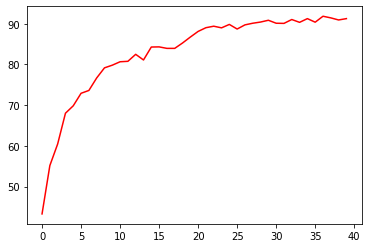

In [ ]:

plt.plot(training_accuracy,"r")
plt.show()

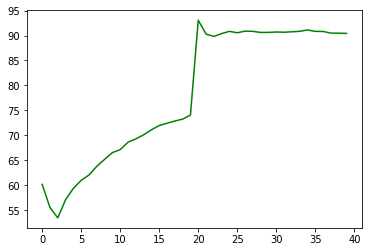

In [ ]:

plt.plot(valid_accuracy,"g")
plt.show()


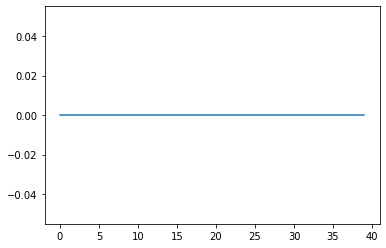

In [ ]:
# co_file = open('/content/drive/MyDrive/PS_Train_losses.txt',"r")
# lines = co_file.readlines()
# train_losses=[]
# for line in lines:
#   train_losses.append(float(line.split("\n")[0]))
plt.plot(train_loss)
plt.show()

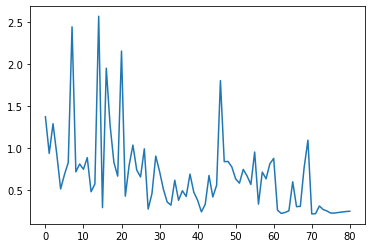

In [ ]:
co_file = open('/content/drive/MyDrive/PS_Valid_losses.txt',"r")
lines = co_file.readlines()
train_losses=[]
for line in lines:
  train_losses.append(float(line.split("(")[1].split(",")[0]))
plt.plot(train_losses)
plt.show()

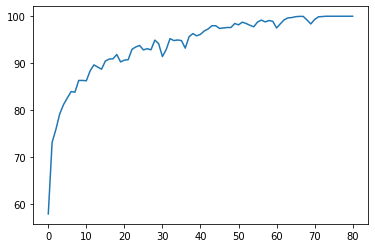

In [ ]:
import matplotlib.pyplot as plt
co_file = open('/content/drive/MyDrive/PS_Acc.txt',"r")
lines = co_file.readlines()
train_losses=[]
for line in lines:
  train_losses.append(float(line.split("\n")[0]))
plt.plot(train_losses)
plt.show()

In [ ]:
total_images=0
total_correct=0
net.load_state_dict(torch.load("/content/drive/MyDrive/PS_30_weigths.pth"))
with torch.no_grad():
      net.eval()
      for i, tdata in enumerate(dataloader_test):
          tinputs, tlabels = tdata
          tinputs, tlabels = tinputs.to(device), tlabels.to(device) 
          toutputs = net(tinputs)
          tloss = criterion(toutputs, tlabels)
          total_images+= tlabels.size(0)
          _, predicted = torch.max(toutputs.data, 1)

          correct = (predicted == tlabels).sum().item()

          total_correct+=correct
          test_acc = ((total_correct / total_images) * 100)

          # Obtaining predictions from max value
          _, predicted = torch.max(toutputs.data, 1)
      net.train()
print()

In [ ]:
test_acc

95.37037037037037